In [1]:
import os
import torch
import clip
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

100%|███████████████████████████████████████| 338M/338M [01:11<00:00, 4.96MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [4]:
IMAGE_DIR = "../data/processed"

In [5]:
def get_image_embedding(image_path):
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(image)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize
    return emb.cpu().numpy()[0]

In [6]:
image_embeddings = []
image_paths = []

for root, _, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(root, file)
            image_embeddings.append(get_image_embedding(path))
            image_paths.append(path)

image_embeddings = np.array(image_embeddings)
print(f"Loaded {len(image_embeddings)} images")

Loaded 118 images


In [7]:
def get_text_embedding(text):
    tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize
    return emb.cpu().numpy()[0]


In [8]:
def search(query, k=5):
    q_emb = get_text_embedding(query).reshape(1, -1)
    sims = cosine_similarity(q_emb, image_embeddings)[0]
    topk = sims.argsort()[::-1][:k]
    return [(image_paths[i], sims[i]) for i in topk]

In [9]:
def show_results(results):
    plt.figure(figsize=(15, 4))
    for i, (path, score) in enumerate(results):
        plt.subplot(1, len(results), i + 1)
        plt.imshow(Image.open(path), cmap="gray")
        plt.axis("off")
        plt.title(f"{score:.3f}")
    plt.show()

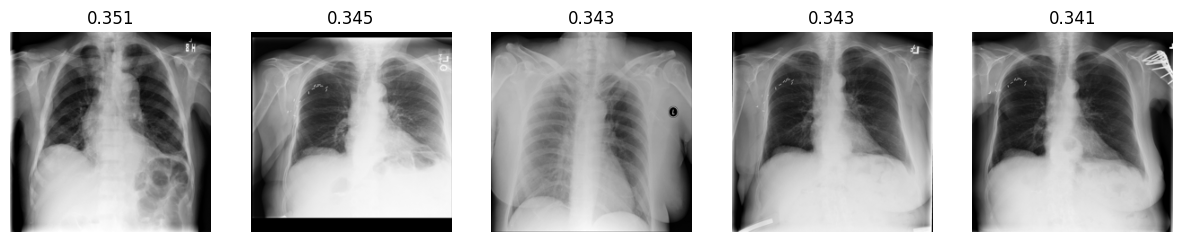

In [10]:
results = search("chest xray showing lungs", k=5)
show_results(results)


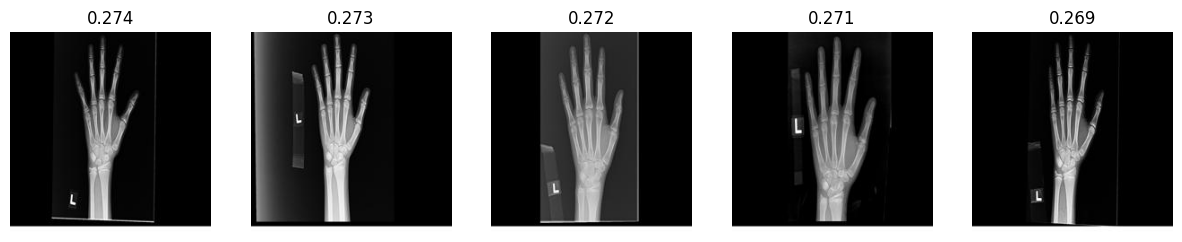

In [12]:
results = search("hand", k=5)
show_results(results)

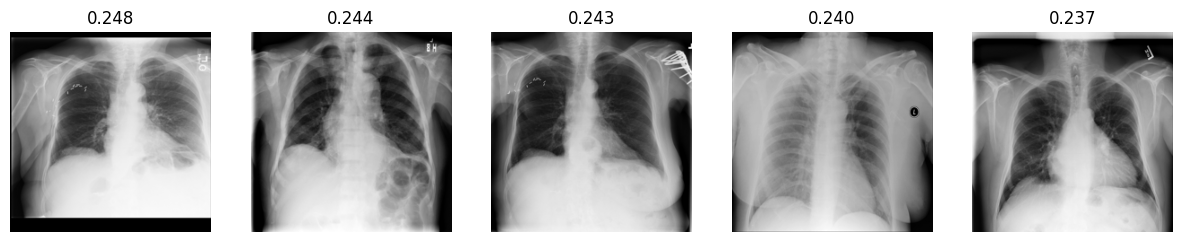

In [13]:
results = search("heart", k=5)
show_results(results)

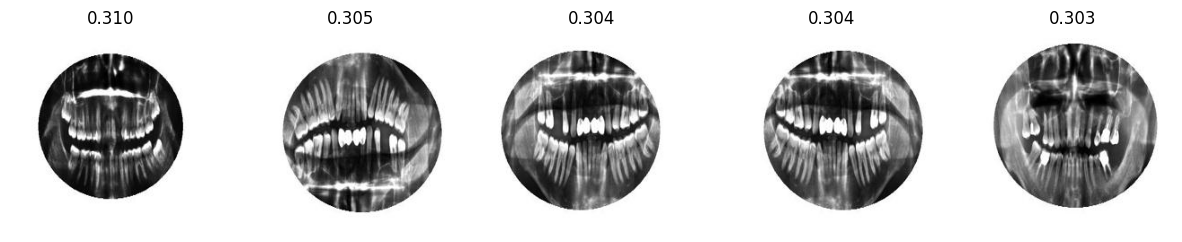

In [15]:
results = search("teeth", k=5)
show_results(results)

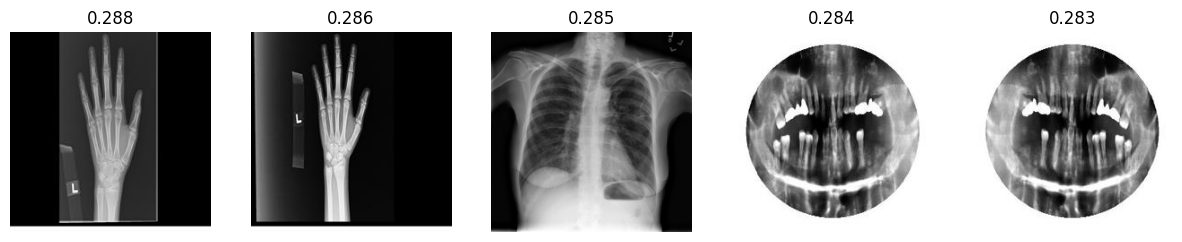

In [16]:
results = search("X_ray", k=5)
show_results(results)

In [18]:
def get_query_image_embedding(query_image_path):
    return get_image_embedding(query_image_path)


In [19]:
def image_search(query_image_path, k=5):
    q_emb = get_query_image_embedding(query_image_path).reshape(1, -1)
    sims = cosine_similarity(q_emb, image_embeddings)[0]
    topk = sims.argsort()[::-1][:k]
    return [(image_paths[i], sims[i]) for i in topk]

In [20]:
def show_image_search(query_image_path, results):
    plt.figure(figsize=(15, 4))

    # show query image
    plt.subplot(1, len(results) + 1, 1)
    plt.imshow(Image.open(query_image_path), cmap="gray")
    plt.axis("off")
    plt.title("QUERY")

    # show results
    for i, (path, score) in enumerate(results):
        plt.subplot(1, len(results) + 1, i + 2)
        plt.imshow(Image.open(path), cmap="gray")
        plt.axis("off")
        plt.title(f"{score:.3f}")

    plt.show()

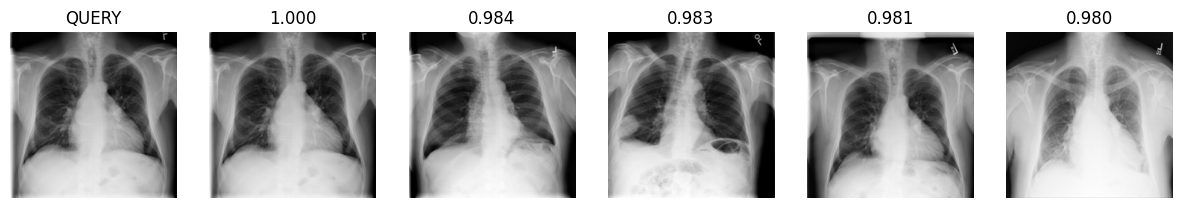

In [21]:
query_img = image_paths[0]
results = image_search(query_img, k=5)
show_image_search(query_img, results)

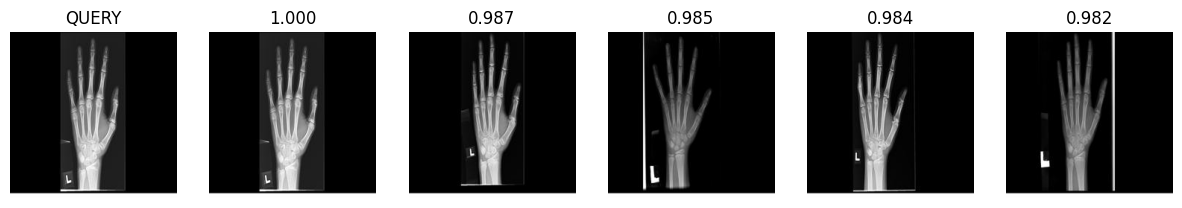

In [22]:
query_img = image_paths[95]
results = image_search(query_img, k=5)
show_image_search(query_img, results)

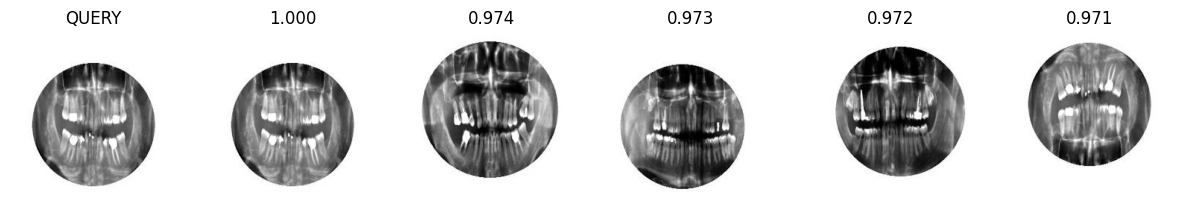

In [24]:
query_img = image_paths[85]
results = image_search(query_img, k=5)
show_image_search(query_img, results)

In [25]:
print(torch.__version__)

2.5.1+cu121
